In [2]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner

In [3]:
def dilser(low=0.001, limit=100., dilfactor=2.):
    '''returns a numpy array dilution series from low to limit by dilfactor'''
    #replace this with a generator/iterator someday
    a = [low]
    while a[-1] <= limit:
        a.append(a[len(a)-1]*dilfactor)
    return np.array(a)

def k1mod(params,ligs,noise=None):
    '''
    theoretical model for single binding site
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    sat = (k1*ligs)/(1 + k1*ligs)

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod(params,ligs,noise=None):
    '''
    theoretical model for a two-site receptor
    
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[1]
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def k2mod_fix(params,ligs,noise=None):
    '''
    returns tuple of ligand concentrations, saturation, params

    params is array of binding constants
    ligs is array of ligand concentrations
    noise is relative percent of gaussian noise (e.g., 0.0-1.) applied to data
    '''

    k1 = params[0]
    k2 = params[0]/4
    sat = (1/2)*((k1*ligs + 2*k1*k2*(ligs**2))/(1 + k1*ligs + k1*k2*(ligs**2)))

    if noise is None:
        return (ligs,sat)
    else:
        noised = np.random.normal(sat,noise*sat)
        return (ligs,noised,params)

def obj(guess,model,data):
    return model(guess,data[0])[1] - data[1]

def obj_wt(guess,model,data,wt):
    return (model(guess,data[0])[1] - data[1])/(wt*data[1])

def fit(data,model,guess):
        return sp.optimize.least_squares(obj,guess,args=(model,data),ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def fit_wt(data,model,guess,wt):
        return sp.optimize.least_squares(obj_wt,guess,args=(model,data,wt),ftol=1e-14,gtol=1e-14,xtol=1e-14)

def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [4]:
def lhood(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/((f*data[1])**2)
    return -0.5*(np.sum((data[1] - model(params,data[0])[1])**2*invsig2 - np.log(invsig2)))

def lnpri(guess,bounds):
    assert len(bounds) == len(guess)
    if all([bounds[i][0] <= guess[i] <= bounds[i][1] for i in range(len(bounds))]) is True:
        return 0.0
    else:
        return -np.inf
    
def lnprob(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood(guess,model,data)

def lhood2(guess,model,data):
    '''
    Gaussian likelihood function for simple binding models. Includes error as 'nuissance' parameter
    guess must contain additional parameter at the last index of the array --- this is the noise parameter
    '''
    params = guess[:-1]
    f = guess[-1] #noise
    invsig2 = 1.0/(data[1]**2 * np.exp(2*f))
    return -0.5*(np.sum(((model(params,data[0])[1] - data[1])**2 * invsig2 - np.log(invsig2))))

def lnprob2(guess,bounds,model,data):
    lp = lnpri(guess,bounds)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood2(guess,model,data)

In [5]:
ligs = dilser()

In [31]:
k1parms = np.array([1.])
k1datset = [k1mod(k1parms,ligs,noise=0.05) for i in range(1000)]

In [13]:
k1datset[0][1] == k1datset[1][1]

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False], dtype=bool)

In [14]:
nll = lambda *args: -lhood(*args)

In [56]:
guess_fork2fit = np.array([9.,9.,0.09])
bnds_fork2fit = ((0.01,10.),(0.01,10.),(0.001,0.1))

In [47]:
res = np.array([sp.optimize.minimize(nll,guess_fork2fit,args=(k2mod,i),method='L-BFGS-B',bounds=bnds_fork2fit,options={'ftol':1e-14,'gtol':1e-14}).x for i in k1datset]) 

(array([  11.,   57.,  143.,  220.,  276.,  184.,   72.,   33.,    3.,    1.]),
 array([ 0.02274079,  0.02848114,  0.0342215 ,  0.03996185,  0.04570221,
         0.05144256,  0.05718292,  0.06292327,  0.06866363,  0.07440399,
         0.08014434]),
 <a list of 10 Patch objects>)

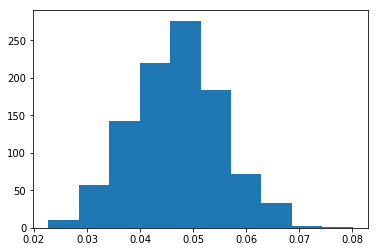

In [48]:
%matplotlib inline
plt.hist(res[:,2])

In [49]:
np.mean(res[:,2])

0.0469160966949572

In [50]:
np.sum((res[:,0]/res[:,1]) < 2)

0

In [51]:
sp.optimize.minimize(nll,guess_fork2fit,args=(k2mod,k1datset[0]),method='L-BFGS-B',bounds=bnds_fork2fit,options={'ftol':1e-14,'gtol':1e-14})

      fun: -80.684377493262275
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([  5.68434189e-06,   4.26325641e-06,   1.42108547e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 112
      nit: 18
   status: 0
  success: True
        x: array([ 1.95660322,  0.50087143,  0.06502202])

In [53]:
def lnpri_EXP(guess):
    k1 = guess[0]
    k2 = guess[1]
    f = guess[2]
    
    if 0.01 < k1 < 10. and 0.01 < k2 < 10. and 0.001 < f < 0.5:
        return 0.0
    else:
        return -np.inf
    

In [57]:
lnpri_EXP(guess_fork2fit)

0.0

In [61]:
def lnprob_EXP(guess,model,data):
    lp = lnpri_EXP(guess)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lhood(guess,model,data)

In [62]:
lnprob_EXP(guess_fork2fit,k2mod,k1datset[0])

-8529.0251466493301

In [63]:
ndim, nwalkers = 3, 100

In [73]:
pos = [guess_fork2fit + 1e-2*np.random.randn(ndim) for i in range(nwalkers)]

In [74]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob_EXP, args=(k2mod,k1datset[0]))

In [76]:
sampler.run_mcmc(pos, 500)

(array([[ 2.01378845,  0.47798529,  0.07895395],
        [ 2.03704832,  0.5095325 ,  0.07740982],
        [ 1.995084  ,  0.44238614,  0.07514855],
        [ 1.98200506,  0.48938863,  0.09212412],
        [ 1.9602852 ,  0.56018334,  0.08026256],
        [ 1.89342074,  0.53996415,  0.07590459],
        [ 1.96818603,  0.51700491,  0.05907619],
        [ 1.95862669,  0.62665946,  0.06488236],
        [ 2.00438744,  0.51136249,  0.06496152],
        [ 1.9862383 ,  0.64144575,  0.0949781 ],
        [ 2.00823899,  0.43774362,  0.07759489],
        [ 1.98312953,  0.54013991,  0.07527612],
        [ 1.92518137,  0.58717768,  0.05691721],
        [ 1.76754003,  0.51948763,  0.09211425],
        [ 1.93646151,  0.43636819,  0.06318815],
        [ 1.90179467,  0.47419118,  0.08765827],
        [ 2.03309326,  0.46755057,  0.05763201],
        [ 2.00936734,  0.66075696,  0.07441287],
        [ 1.92539104,  0.51824537,  0.05497643],
        [ 1.92191017,  0.52720074,  0.07102489],
        [ 1.9295709 

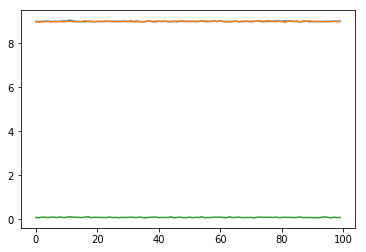

In [83]:
plt.plot(sampler.chain[:,1,:])

In [84]:
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

(array([ 80285.,   2933.,   1592.,   1136.,   1059.,    908.,   1019.,
          1084.,   2374.,   2610.]),
 array([ 0.0279716 ,  1.02288652,  2.01780144,  3.01271636,  4.00763128,
         5.0025462 ,  5.99746112,  6.99237604,  7.98729096,  8.98220588,
         9.97712081]),
 <a list of 10 Patch objects>)

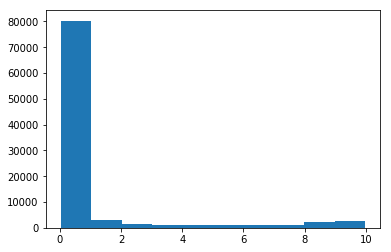

In [87]:
plt.hist(samples[:,1])

NameError: name 'MaxNLocator' is not defined

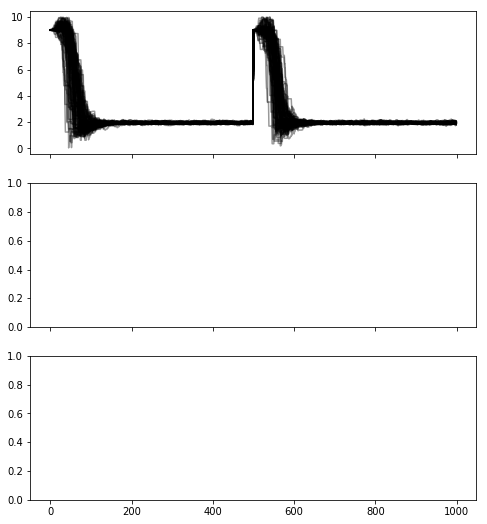

In [91]:
plt.clf()
fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
axes[0].plot(sampler.chain[:, :, 0].T, color="k", alpha=0.4)
axes[0].yaxis.set_major_locator(MaxNLocator(5))
axes[0].axhline(m_true, color="#888888", lw=2)
axes[0].set_ylabel("$m$")

axes[1].pltot(samplter.chain[:, :, 1].T, color="k", alpha=0.4)
axes[1].yaxis.set_major_locator(MaxNLocator(5))
axes[1].axhline(b_true, color="#888888", lw=2)
axes[1].set_ylabel("$b$")

axes[2].pltot(np.exp(samplter.chain[:, :, 2]).T, color="k", alpha=0.4)
axes[2].yaxis.set_major_locator(MaxNLocator(5))
axes[2].axhline(f_true, color="#888888", lw=2)
axes[2].set_ylabel("$f$")
axes[2].set_xlabel("step number")